# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP with fewer neurons.  
Train on copious simulated data.  
Use uniform but shorter RNA lengths: 500 
Lower accuracy: 66%.


## This error went away after computer restart.
InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-16 10:54:21 EDT


In [2]:
PC_TRAINS=50000
NC_TRAINS=50000
PC_TESTS=5000
NC_TESTS=5000   
RNA_LEN=500  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=32
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-16 10:54:22.486957: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/DataPrep.py')
    with open('DataPrep.py', 'w') as f:
        f.write(r.text)  
    from DataPrep import DataPrep
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
        from SimTools.DataPrep import DataPrep
BESTMODELPATH=DATAPATH+"BestModel"  
LASTMODELPATH=DATAPATH+"LastModel"  

CoLab not working. On my PC, use relative paths.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-16 10:54:23 EDT
Generated 55000 PC seqs
Generated 55000 NC seqs


In [6]:
print("Simulated sequence characteristics:")
oc = ORF_counter()
print("PC seqs")
oc.describe_sequences(pc_all)
print("NC seqs")
oc.describe_sequences(nc_all)
oc=None
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 500.0
Average ORF length: 336.75643636363634
NC seqs
Average RNA length: 500.0
Average ORF length: 126.28341818181818
2021-08-16 10:54:34 EDT


## Data Prep

In [7]:
dp = DataPrep()
Xseq,y=dp.combine_pos_and_neg(pc_all,nc_all)
nc_all=None
pc_all=None
nc_all=None
print("The first few shuffled labels:")
print(y[:30])
show_time()

The first few shuffled labels:
[1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0]
2021-08-16 10:54:34 EDT


In [8]:
Xfrq=KmerTools.seqs_to_kmer_freqs(Xseq,MAX_K)
Xseq = None
y=np.asarray(y)
show_time()

{'A': 0.266, 'C': 0.252, 'G': 0.23, 'T': 0.252, 'AA': 0.06412825651302605, 'AC': 0.056112224448897796, 'AG': 0.06813627254509018, 'AT': 0.07615230460921844, 'CA': 0.06212424849699399, 'CC': 0.07615230460921844, 'CG': 0.056112224448897796, 'CT': 0.05811623246492986, 'GA': 0.06813627254509018, 'GC': 0.056112224448897796, 'GG': 0.04609218436873747, 'GT': 0.06012024048096192, 'TA': 0.07214428857715431, 'TC': 0.06412825651302605, 'TG': 0.06012024048096192, 'TT': 0.056112224448897796, 'AAA': 0.02208835341365462, 'AAC': 0.010040160642570281, 'AAG': 0.018072289156626505, 'AAT': 0.012048192771084338, 'ACA': 0.008032128514056224, 'ACC': 0.014056224899598393, 'ACG': 0.012048192771084338, 'ACT': 0.02208835341365462, 'AGA': 0.02208835341365462, 'AGC': 0.012048192771084338, 'AGG': 0.01606425702811245, 'AGT': 0.018072289156626505, 'ATA': 0.02208835341365462, 'ATC': 0.02610441767068273, 'ATG': 0.014056224899598393, 'ATT': 0.014056224899598393, 'CAA': 0.012048192771084338, 'CAC': 0.010040160642570281, 

In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 100000 = 100000
Reserved test set size= 10000 = 10000
2021-08-16 10:54:48 EDT


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2720      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)        

2021-08-16 10:54:48.996465: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 10:54:49.071202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-16 10:54:49.073495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-16 10:54:49.073631: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 10:54:49.086935: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-16 10:54:49.086994: I tensorflow/stream_executor

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-16 10:54:49 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200


2021-08-16 10:54:49.911069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 10:54:49.929829: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-16 10:54:56.396892: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 161/2084 [=>............................] - ETA: 1s - loss: 0.7282 - accuracy: 0.5083 

2021-08-16 10:54:56.957168: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2084/2084 [==============================] - 10s 1ms/step - loss: 0.7079 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.5009


2021-08-16 10:54:59.880884: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 2/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 3/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6934 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4991
Epoch 4/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 5/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 6/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.4991
Epoch 7/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 8/200
2084/2084 [==============================] - 2s 1ms/step - lo

INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 49/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6361 - accuracy: 0.6388 - val_loss: 0.6228 - val_accuracy: 0.6537
Epoch 50/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6354 - accuracy: 0.6390 - val_loss: 0.6234 - val_accuracy: 0.6534
Epoch 51/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6380 - accuracy: 0.6375 - val_loss: 0.6210 - val_accuracy: 0.6544
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 52/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6348 - accuracy: 0.6386 - val_loss: 0.6217 - val_accuracy: 0.6549
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 53/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6345 - accuracy: 0.6386 - val_loss: 0.6213 - val_accuracy: 0.6546
Epoch 54/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6333 - accuracy: 0.

Epoch 98/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6257 - accuracy: 0.6501 - val_loss: 0.6166 - val_accuracy: 0.6600
Epoch 99/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6246 - accuracy: 0.6509 - val_loss: 0.6160 - val_accuracy: 0.6600
Epoch 100/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6264 - accuracy: 0.6494 - val_loss: 0.6158 - val_accuracy: 0.6602
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 101/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6258 - accuracy: 0.6497 - val_loss: 0.6159 - val_accuracy: 0.6602
Epoch 102/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6241 - accuracy: 0.6521 - val_loss: 0.6171 - val_accuracy: 0.6603
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 103/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6262 - accuracy: 0.6481 - val_loss: 0.6169 - val_accuracy: 0.6599
Epoch 

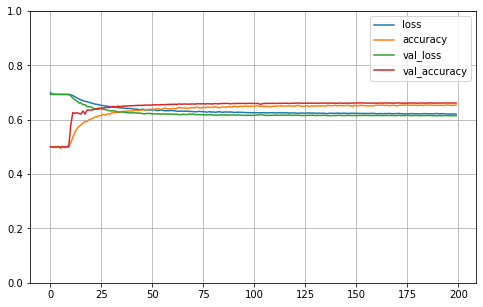

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7063 - accuracy: 0.4964 - val_loss: 0.6936 - val_accuracy: 0.5006
Epoch 2/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6939 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 3/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 4/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 5/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 6/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 7/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - a

Epoch 57/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6335 - accuracy: 0.6403 - val_loss: 0.6220 - val_accuracy: 0.6550
Epoch 58/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6337 - accuracy: 0.6396 - val_loss: 0.6181 - val_accuracy: 0.6583
Epoch 59/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6324 - accuracy: 0.6405 - val_loss: 0.6176 - val_accuracy: 0.6581
Epoch 60/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6341 - accuracy: 0.6416 - val_loss: 0.6185 - val_accuracy: 0.6611
Epoch 61/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6316 - accuracy: 0.6425 - val_loss: 0.6178 - val_accuracy: 0.6594
Epoch 62/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6329 - accuracy: 0.6389 - val_loss: 0.6179 - val_accuracy: 0.6586
Epoch 63/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6347 - accuracy: 0.6386 - val_loss: 0.6166 -

Epoch 167/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6227 - accuracy: 0.6542 - val_loss: 0.6145 - val_accuracy: 0.6588
Epoch 168/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6235 - accuracy: 0.6531 - val_loss: 0.6133 - val_accuracy: 0.6604
Epoch 169/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6260 - accuracy: 0.6478 - val_loss: 0.6143 - val_accuracy: 0.6584
Epoch 170/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6207 - accuracy: 0.6558 - val_loss: 0.6138 - val_accuracy: 0.6607
Epoch 171/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6229 - accuracy: 0.6530 - val_loss: 0.6138 - val_accuracy: 0.6596
Epoch 172/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6225 - accuracy: 0.6538 - val_loss: 0.6133 - val_accuracy: 0.6601
Epoch 173/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6238 - accuracy: 0.6484 - val_loss: 0

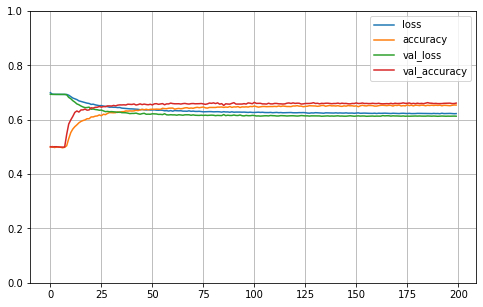

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7060 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.4976
Epoch 2/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6939 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 3/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 4/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 5/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 6/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4976
Epoch 7/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - a

Epoch 57/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6329 - accuracy: 0.6389 - val_loss: 0.6214 - val_accuracy: 0.6544
Epoch 58/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6357 - accuracy: 0.6399 - val_loss: 0.6200 - val_accuracy: 0.6561
Epoch 59/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6336 - accuracy: 0.6416 - val_loss: 0.6202 - val_accuracy: 0.6547
Epoch 60/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6300 - accuracy: 0.6435 - val_loss: 0.6203 - val_accuracy: 0.6554
Epoch 61/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6370 - accuracy: 0.6363 - val_loss: 0.6192 - val_accuracy: 0.6555
Epoch 62/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6333 - accuracy: 0.6423 - val_loss: 0.6199 - val_accuracy: 0.6555
Epoch 63/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6321 - accuracy: 0.6429 - val_loss: 0.6206 -

2084/2084 [==============================] - 2s 1ms/step - loss: 0.6267 - accuracy: 0.6503 - val_loss: 0.6163 - val_accuracy: 0.6575
Epoch 114/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6299 - accuracy: 0.6488 - val_loss: 0.6152 - val_accuracy: 0.6580
Epoch 115/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6283 - accuracy: 0.6480 - val_loss: 0.6179 - val_accuracy: 0.6562
Epoch 116/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6280 - accuracy: 0.6499 - val_loss: 0.6162 - val_accuracy: 0.6573
Epoch 117/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6286 - accuracy: 0.6453 - val_loss: 0.6154 - val_accuracy: 0.6574
Epoch 118/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6269 - accuracy: 0.6515 - val_loss: 0.6155 - val_accuracy: 0.6577
Epoch 119/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6264 - accuracy: 0.6494 - val_loss: 0.6164 - val_ac

Epoch 169/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6217 - accuracy: 0.6545 - val_loss: 0.6148 - val_accuracy: 0.6585
Epoch 170/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6228 - accuracy: 0.6541 - val_loss: 0.6154 - val_accuracy: 0.6583
Epoch 171/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6234 - accuracy: 0.6550 - val_loss: 0.6144 - val_accuracy: 0.6585
Epoch 172/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6232 - accuracy: 0.6538 - val_loss: 0.6166 - val_accuracy: 0.6583
Epoch 173/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6235 - accuracy: 0.6533 - val_loss: 0.6144 - val_accuracy: 0.6581
Epoch 174/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6232 - accuracy: 0.6525 - val_loss: 0.6153 - val_accuracy: 0.6583
Epoch 175/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6248 - accuracy: 0.6543 - val_loss: 0

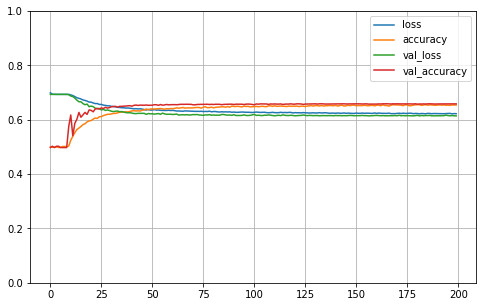

In [12]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [13]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
2021-08-16 11:19:43 EDT


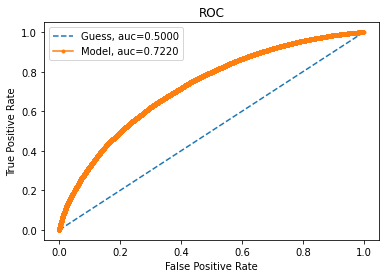

AUC: 72.20%
accuracy: 66.04%
2021-08-16 11:19:47 EDT


In [14]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

Accuracy on test data.
2021-08-16 11:19:47 EDT


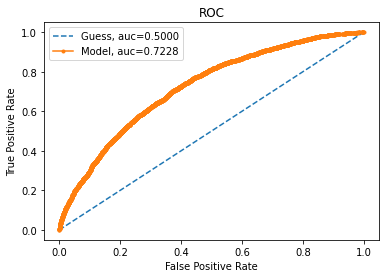

AUC: 72.28%
accuracy: 65.93%
2021-08-16 11:19:48 EDT


In [15]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(best_model,X_test,y_test)
show_time()